In [1]:
# class Lambda(nn.Module):

#     def __init__(self, fn):
#         super(Lambda, self).__init__()
#         self.fn = fn

#     def forward(self, x):
#         return self.fn(x)

In [2]:
import learn2learn as l2l
for name in l2l.vision.benchmarks.list_tasksets():
    print(name)
    if("tiered-imagenet" == name):
        continue
    tasksets = l2l.vision.benchmarks.get_tasksets(name)

omniglot
Files already downloaded and verified
Files already downloaded and verified
mini-imagenet
tiered-imagenet
fc100
cifarfs


In [3]:
Datasets = [
    "omniglot",]
#             "mini-imagenet", 
#             "fc100", "cifarfs", "tiered-imagenet"]
# WaysAndShots = ["omniglot", "mini-imagenet", "fc100", "cifarfs", "tiered-imagenet"]
#!/usr/bin/env python3

"""
Demonstrates how to:
    * use the MAML wrapper for fast-adaptation,
    * use the benchmark interface to load Omniglot, and
    * sample tasks and split them in adaptation and evaluation sets.
"""

import random
import numpy as np
import torch
import learn2learn as l2l
import matplotlib.pyplot as plt
from torch import nn, optim
import os

############### omniglot ###############
Files already downloaded and verified
Files already downloaded and verified


Iteration 0
Meta Train Error 1.5664074830710888
Meta Train Accuracy 0.33750000735744834
Meta Valid Error 1.5736553594470024
Meta Valid Accuracy 0.2875000066123903
Meta Test Error 1.4665710218250751
Meta Test Accuracy 0.40000001015141606
############### omniglot ###############
Files already downloaded and verified
Files already downloaded and verified


Iteration 0
Meta Train Error 1.5664074830710888
Meta Train Accuracy 0.33750000735744834
Meta Valid Error 1.5736553594470024
Meta Valid Accuracy 0.2875000066123903


Iteration 32
Meta Train Error 1.0495170950889587
Meta Train Accuracy 0.5812500109896064
Meta Valid Error 1.0092181013897061
Meta Valid Accuracy 0.6187500106170774


Iteration 64
Meta Train Error 0.8851228686980903
Meta Train Accuracy 0.7062500067986548
Meta Valid Error 0.8873503152281046
Meta Valid Accuracy 0.6437500123865902


Iteration 96
Meta Train Error 

KeyboardInterrupt: 

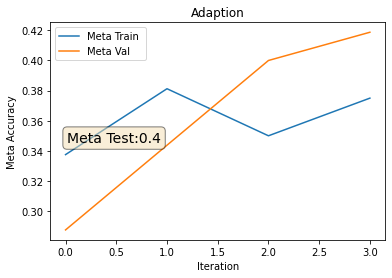

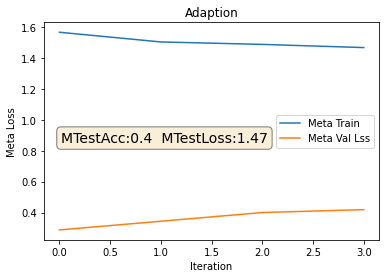

In [5]:
def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)


def fast_adapt(batch, learner, loss, adaptation_steps, shots, ways, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)

    # Separate data into adaptation/evalutation sets
    adaptation_indices = np.zeros(data.size(0), dtype=bool)
    adaptation_indices[np.arange(shots*ways) * 2] = True
    evaluation_indices = torch.from_numpy(~adaptation_indices)
    adaptation_indices = torch.from_numpy(adaptation_indices)
    adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
    evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

    # Adapt the model
    for step in range(adaptation_steps):
        train_error = loss(learner(adaptation_data), adaptation_labels)
        learner.adapt(train_error)

    # Evaluate the adapted model
    predictions = learner(evaluation_data)
    valid_error = loss(predictions, evaluation_labels)
    valid_accuracy = accuracy(predictions, evaluation_labels)
    return valid_error, valid_accuracy


def perform_experiment(
        dataset,
        ways=5,
        shots=1,
        meta_lr=0.003,
        fast_lr=0.5,
        meta_batch_size=32,
        adaptation_steps=1,
        num_iterations=64,#60000,
        cuda=True,
        seed=42,
        
):
    print("############### {0} ###############".format(dataset))
    Meta_Train_Accuracy = []
    Meta_Train_Error = []
    Meta_Val_Accuracy = []
    Meta_Val_Error = []
#     Iterations = []
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    device = torch.device('cpu')
    if cuda:
        torch.cuda.manual_seed(seed)
        device = torch.device('cuda')

    # Load train/validation/test tasksets using the benchmark interface
    tasksets = l2l.vision.benchmarks.get_tasksets(dataset,
                                                  train_ways=ways,
                                                  train_samples=2*shots,
                                                  test_ways=ways,
                                                  test_samples=2*shots,
                                                  num_tasks=20000,
                                                  root='~/data',
    )

    #     "omniglot",
#             "mini-imagenet", 
#             "fc100", "cifarfs", "tiered-imagenet"
    # Create model
    if(dataset == "omniglot"):
        model = l2l.vision.models.OmniglotFC(28 ** 2, ways)
    elif(dataset == "mini-imagenet"):
        model = l2l.vision.models.MiniImagenetCNN(ways)
    elif(dataset == "fc100"):
        features = l2l.vision.models.ConvBase(output_size=64, channels=3, max_pool=True)
        features = torch.nn.Sequential(features, Lambda(lambda x: x.view(-1, 256)))
        features.to(device)
        model = torch.nn.Linear(256, ways)
#     elif(dataset = ""):
    else:
        print("Error occured.")
        
    
    model.to(device)
    maml = l2l.algorithms.MAML(model, lr=fast_lr, first_order=False)
    opt = optim.Adam(maml.parameters(), meta_lr)
    loss = nn.CrossEntropyLoss(reduction='mean')

    for iteration in range(num_iterations):
        opt.zero_grad()
        meta_train_error = 0.0
        meta_train_accuracy = 0.0
        meta_valid_error = 0.0
        meta_valid_accuracy = 0.0
        for task in range(meta_batch_size):
            # Compute meta-training loss
            learner = maml.clone()
            batch = tasksets.train.sample()
            evaluation_error, evaluation_accuracy = fast_adapt(batch,
                                                               learner,
                                                               loss,
                                                               adaptation_steps,
                                                               shots,
                                                               ways,
                                                               device)
            evaluation_error.backward()
            meta_train_error += evaluation_error.item()
            meta_train_accuracy += evaluation_accuracy.item()

            # Compute meta-validation loss
            learner = maml.clone()
            batch = tasksets.validation.sample()
            evaluation_error, evaluation_accuracy = fast_adapt(batch,
                                                               learner,
                                                               loss,
                                                               adaptation_steps,
                                                               shots,
                                                               ways,
                                                               device)
            meta_valid_error += evaluation_error.item()
            meta_valid_accuracy += evaluation_accuracy.item()

        # Print some metrics
        
        
        meta_train_error =  meta_train_error / meta_batch_size
        meta_train_accuracy = meta_train_accuracy / meta_batch_size
        meta_val_error =  meta_valid_error / meta_batch_size
        meta_val_accuracy = meta_valid_accuracy / meta_batch_size
        if(iteration % 32 ==0):
            print('\n')
            print('Iteration', iteration)
            print('Meta Train Error', meta_train_error)
            print('Meta Train Accuracy', meta_train_accuracy)
            print('Meta Valid Error', meta_val_error)
            print('Meta Valid Accuracy', meta_val_accuracy)

        Meta_Train_Accuracy.append(meta_train_accuracy)
        Meta_Train_Error.append(meta_train_error)
        Meta_Val_Accuracy.append(meta_val_accuracy)
        Meta_Val_Error.append(meta_val_error)

        # Average the accumulated gradients and optimize
        for p in maml.parameters():
            p.grad.data.mul_(1.0 / meta_batch_size)
        opt.step()

    meta_test_error = 0.0
    meta_test_accuracy = 0.0
    for task in range(meta_batch_size):
        # Compute meta-testing loss
        learner = maml.clone()
        batch = tasksets.test.sample()
        evaluation_error, evaluation_accuracy = fast_adapt(batch,
                                                           learner,
                                                           loss,
                                                           adaptation_steps,
                                                           shots,
                                                           ways,
                                                           device)
        meta_test_error += evaluation_error.item()
        meta_test_accuracy += evaluation_accuracy.item()
    Meta_Test_Error = meta_test_error / meta_batch_size
    print('Meta Test Error', Meta_Test_Error)
    Meta_Test_Accuracy = meta_test_accuracy / meta_batch_size
    print('Meta Test Accuracy', Meta_Test_Accuracy)
    
    if not os.path.exists('plots'):
        os.makedirs('plots')
    if not os.path.exists('plots/acc'):
        os.makedirs('plots/acc')
    if not os.path.exists('plots/loss'):
        os.makedirs('plots/loss')
    ###### Plot Accuracies ######
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(list(range(0, len(Meta_Train_Accuracy))), Meta_Train_Accuracy, label="Meta Train ")
    ax.plot(list(range(0, len(Meta_Val_Accuracy))), Meta_Val_Accuracy, label="Meta Val")
#     ax.text((len(Meta_Val_Accuracy)/2), 0, 'Meta Test:{0}'.format(round(meta_test_accuracy, 2)), style='italic',
#         bbox={'facecolor': 'red', 'alpha': 0.25, 'pad': 5})
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.5, 'Meta Test:{0}'.format(round(Meta_Test_Accuracy, 2)), transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    plt.title('Adaption')
    plt.xlabel('Iteration')
    plt.ylabel('Meta Accuracy')
    ax.legend()
    plt.savefig('./plots/acc/{0}_ways_{1}_shots_{2}_Acc_I_{3}.png'.format(dataset, ways, shots, iteration), 
                dpi=150)
    ###### Plot Accuracies ######

    ###### Plot Errors ######
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(list(range(0, len(Meta_Train_Error))), Meta_Train_Error, label="Meta Train ")
    ax.plot(list(range(0, len(Meta_Val_Error))), Meta_Val_Accuracy, label="Meta Val Lss")
#     ax.text((len(Meta_Val_Accuracy)/2),0, 'Meta Test Accuracy:{0}  Meta Test Loss:{1}'.format(round(meta_test_accuracy, 2),
#                               round(meta_test_error, 2)), style='italic',
#         bbox={'facecolor': 'red', 'alpha': 0.25, 'pad': 5})
    ax.text(0.05, 0.5, 'MTestAcc:{0}  MTestLoss:{1}'.format(round(Meta_Test_Accuracy, 2),
                                           round(Meta_Test_Error, 2)), transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    plt.title('Adaption')
    plt.xlabel('Iteration')
    plt.ylabel('Meta Loss')
    ax.legend()
    plt.savefig('./plots/loss/{0}_ways_{1}_shots_{2}_Loss_I_{3}.png'.format(dataset, ways, shots, iteration),
               dpi=150)
    ###### Plot Errors ######


if __name__ == '__main__':
    Ways = [5]
    Shots = [1, 5]
    Iterations = [4, 10000, 60000, 120000]
    for ways in Ways:
        for shots in Shots:
            for iteration in Iterations:
                for dataset in Datasets:
                    perform_experiment(dataset=dataset,
                        ways=ways,
                        shots=shots,
                        meta_lr=0.003,
                        fast_lr=0.5,
                        meta_batch_size=32,
                        adaptation_steps=1,
                        num_iterations=iteration,
                        cuda=True,
                        seed=42)
    

In [ ]:
# round(12.54673, 2)

In [ ]:


# fig = plt.figure()
# ax = plt.subplot()
# ax.plot(list(range(0, (10))), list(range(0, (10))), label="Meta Train")
# ax.text(5, 0, 'Meta Test:95%', style='italic',
#         bbox={'facecolor': 'red', 'alpha': 0.25, 'pad': 5}, ha='center', va='center')
# # ax.plot(list(range(0, len(Meta_Val_Accuracy))), Meta_Val_Accuracy, label="Meta Val")
# plt.title('Adaption')
# plt.xlabel('Iteration')
# plt.ylabel('Meta Accuracy')
# ax.legend()
# # plt.show()



# # plt.plot(list(range(0, len(Meta_Train_Accuracy))), Meta_Train_Accuracy,
# #         list(range(0, len(Meta_Val_Accuracy))), Meta_Val_Accuracy, label = ("A", "B"))#, list(range(0, len(Meta_Train_Error))), 
# #          Meta_Train_Error)#,label = ["Meta Train Accuracy", "Meta Train Error"])
# plt.savefig('foo.png')

In [ ]:
# plt.plot(list(range(0, len(Meta_Train_Accuracy))), Meta_Train_Accuracy,
#         list(range(0, len(Meta_Val_Accuracy))), Meta_Val_Accuracy, label = ("A", "B"))#, list(range(0, len(Meta_Train_Error))), 
# #          Meta_Train_Error)#,label = ["Meta Train Accuracy", "Meta Train Error"])

In [32]:
#Define the network
linear = l2l.algorithms.MAML(nn.Linear(20, 10), lr=0.01)
#Clone the parameters
clone = linear.clone()
#Compute loss with cloned network
error = loss(clone(X), y)
#Adapt clone network
clone.adapt(error)
#Meta loss
error = loss(clone(X), y)
#Back-propage the meta loss
error.backward()

NameError: name 'loss' is not defined

In [30]:
import torch
from torch import nn

In [31]:
print(nn.Parameter(torch.zeros([2,2]), requires_grad=True))
# nn.Parameter()

Parameter containing:
tensor([[0., 0.],
        [0., 0.]], requires_grad=True)


In [18]:
tn = torch.randn((3,3))
print(tn)

tensor([[ 0.1364,  0.4121,  0.9692],
        [-0.9406, -0.5043, -0.3111],
        [ 0.8967, -1.3596, -0.4991]])


In [23]:
print(torch.diagonal(tn, -2))

tensor([0.8967])


In [25]:
# help(torch.diagonal)